# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import sem, t
from scipy import mean

import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers.core import Dense, Activation, Dropout

In [3]:
# def min_max_range(samples,loci):
#     min_list = []
#     max_list = []
#     for i in range(0,1000):
#         f_M = np.random.uniform(0,1,loci)
#         G = np.random.binomial(n=2,p = f_M, size = (samples,loci))
#         G = preprocessing.scale(G, axis=0)
#         min1 = np.min(G)
#         max1 = np.max(G)
#         min_list.append(min1)
#         max_list.append(max1)
#     mean_min = np.mean(min_list)
#     mean_max = np.mean(max_list)
#     return mean_min,mean_max

In [4]:
#Simulate Genotype
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    assert(len(G) == samples_n)
    assert(len(G[0])== loci_m)
    return G

In [12]:
def simulate_genotype_neutral(samples_n, loci_m,beta_g,e_noise):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    b_i = beta_g
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a e_j(noise) value
        e_j = np.random.normal(0, e_noise)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    y_max = np.max(Y_n)
    y_max = abs(y_max)
    Y_n = np.array(Y_n)
    Y_n = Y_n/y_max
    Y_n = Y_n.reshape(samples_n,1)
    G = np.append(G, Y_n, axis=1)
    return G

In [13]:
# #Provide beta_g, e_noise and get G with genotype & Phenotype data
# def simulate_genotype_neutral(samples_n, loci_m):
#     G = simulate_genotype(samples_n, loci_m)
#     #randomly generated causal loci
#     mu, sigma = 0, 1 # mean and standard deviation
#     Y_n = np.random.normal(mu, sigma, samples_n)
#     y_max = np.max(Y_n)
#     y_max = abs(y_max)
#     Y_n = np.array(Y_n)
#     Y_n = Y_n/y_max
#     Y_n = Y_n.reshape(samples_n,1)
#     G = np.append(G, Y_n, axis=1)
#     return G

In [27]:
def shap_RFR_tree_train(G):
    X = G[:,0:len(G[0])-1]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    forReg = RandomForestRegressor(max_depth=20, min_samples_split =5,min_samples_leaf=4,random_state=0, n_estimators=1000)
    forReg.fit(x_train, y_train)
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    return shap_values

def shap_feature_plot_RFR(shap_values, x_train):
    shap.summary_plot(shap_values, x_train, plot_type="bar")

In [28]:
# def shap_RFR_tree_train(G):
#     X = G[:,0:len(G[0])-1]
#     y = G[:,len(G[0])-1]
#     x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#     linReg = LinearRegression() 
#     linReg.fit(x_train, y_train) 
#     explainer = shap.KernelExplainer(linReg.predict, shap.kmeans(x_train,50))
#     shap_values = explainer.shap_values(x_test)
#     return shap_values

In [29]:
def mean_shap_values(shap_values):
    
    shap_values = np.array(shap_values)
    avg_shap = []
    for i in range(0,len(shap_values[0])):
        shap2 = np.mean(abs(shap_values[:,i]))
        avg_shap.append(shap2)
    return avg_shap

In [30]:
def max_mean_feature(shap_values):
    avg_shap = mean_shap_values(shap_values)
    temp1 = np.asarray(avg_shap)
    indices = temp1.argsort()[-2:][::-1]
    loci1,loci2 = avg_shap[indices[0]],avg_shap[indices[1]]
    return indices[0], loci1

In [33]:
loci  = 20
samples =500
max_shap = 0
var_g_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
var_e_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

max_shap_list = []
for i in range(0,1000):
    var_g = random.choice(var_g_list)
    var_e = random.choice(var_e_list)
    G_Phen = simulate_genotype_neutral(samples,loci,var_g,var_e)
    shap_vals = shap_RFR_tree_train(G_Phen)
    index,loci1 = max_mean_feature(shap_vals)
    max_shap_list.append(loci1)

In [35]:
with open('/Users/kevin/Downloads/threshhold_LR_scaled_SHAP', 'wb') as fp:
    pickle.dump(max_shap_list, fp)

In [3]:
with open ('/Users/kevin/Desktop/UCLA_BIG_Code/Code_Data/threshhold_LR_scaled_neutral', 'rb') as fp:
    neutral_list = pickle.load(fp)

In [4]:
with open ('/Users/kevin/Desktop/UCLA_BIG_Code/Code_Data/threshhold_LR_scaled_SHAP', 'rb') as fp:
    shap_list = pickle.load(fp)

In [43]:
np.max(corr2list)

0.04023644593676834

In [41]:
np.max(max_shap_list)

0.9469638249276934

In [ ]:
a=np.arange(1,1001)

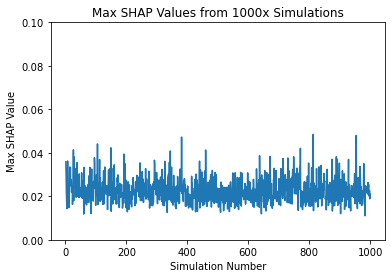

In [71]:
plt.plot(a,corr2list)
plt.ylim([0,.1])
plt.ylabel('Max SHAP Value')
plt.xlabel('Simulation Number')
plt.title('Max SHAP Values from 1000x Simulations')
plt.savefig('neutral_loci_plt')

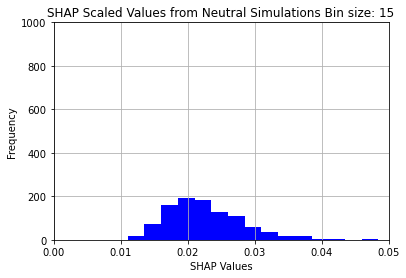

In [91]:
bin_size = 15
count, bins, ignored = plt.hist(corr2list, bin_size, facecolor='blue') 

plt.xlabel('SHAP Values')
plt.ylabel('Frequency')
plt.title("SHAP Scaled Values from Neutral Simulations Bin size: "+str(bin_size))
# plt.axis([0, .05, 0, 1000]) # x_start, x_end, y_start, y_end
plt.grid(True)
plt.savefig('Hist_SHAP_Neutral_Scaled_True')
plt.show(block = False)

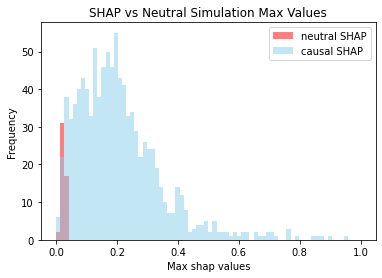

In [5]:
# bin_size = 100
bin_size = np.linspace(0, 1,75)

plt.hist(neutral_list, bin_size, alpha=0.5, label='neutral SHAP',color = "red")
plt.hist(shap_list, bin_size, alpha=0.5, label='causal SHAP',color = "skyblue")
plt.legend(loc='upper right')
plt.title('SHAP vs Neutral Simulation Max Values')
plt.ylabel('Frequency')
plt.xlabel('Max shap values')
plt.savefig('SHAP_vs_Neutral_Hist')
plt.show()